In [1]:

import warnings
warnings.filterwarnings('ignore')
import datetime
from torch.utils.data import Dataset
from skimage.transform import resize
import cv2
from zipfile import ZipFile
import os
import torch
from sklearn.utils import shuffle

import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from Dataset import Dataset,Scale,ToTensor,visualize_loader,Normalize
from Models.Facenet import Resnet34Triplet
from Models.M2FPA import load_model,save_model,set_requires_grad\
,init_weights,Generator,Discriminator,ParserDiscriminator
from Models.Bisnet import BiSeNet,vis_parsing_maps,re_normalize_batch,ParserMaps
from Losses import TVLoss,DetectionLoss
import skimage
from skimage.io import imread,imsave
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm 
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import os
import shutil
import random
import pandas as pd
import torchvision.transforms as transforms


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
    
BATCH_SIZE=16
START_EPOCHS=0
END_EPOCHS=10
CRITIC_ITER=10

LAMBDA_PIXEL=1
LAMBDA_DETECT=0.1
LAMBDA_ADV_PARSER=0.01
LAMBDA_TV=0.001
LAMBDA_ADV=0.08



In [3]:
transform=torchvision.transforms.Compose([Scale(),ToTensor(),Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_dataset=Dataset('M2FPA_TRAIN.csv',transform)
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
NO_STEPS=train_dataset.__len__()//BATCH_SIZE
print("NUMBER OF BATCHES : ",train_loader.__len__())

NUMBER OF BATCHES :  16160


MAX VALUE TENSOR:  
input_image 0.6392157 
gt_image 0.6156863
MIN VALUE TENSOR:  
input_image -1.0 
gt_image -0.9843137
TENSOR SIZE :  
input_image (3, 256, 256) 
gt_image (3, 256, 256)
MAX VALUE :  
input_image 209 
gt_image 206
MIN VALUE :  
input_image 0 
gt_image 1
IMG SIZE :  
input_image (256, 256, 3) 
gt_image (256, 256, 3)


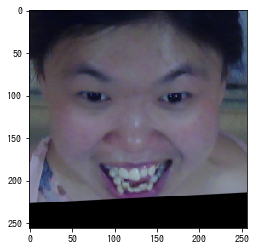

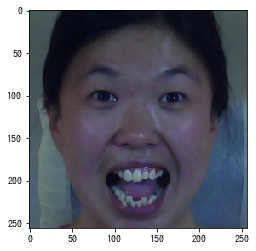

In [4]:
input_image,gt_image=visualize_loader(train_loader,index=1)
print("MAX VALUE : ","\ninput_image",np.max(input_image),"\ngt_image",np.max(gt_image))
print("MIN VALUE : ","\ninput_image",np.min(input_image),"\ngt_image",np.min(gt_image))
print("IMG SIZE : ","\ninput_image",input_image.shape,"\ngt_image",gt_image.shape)
plt.imshow(input_image);plt.show()
plt.imshow(gt_image);plt.show()

In [5]:

model_parser=BiSeNet(19)
load_model('Weights/Parser.pth',model_parser)
model_detect=Resnet34Triplet()
load_model('Weights/Facenet.pth',model_detect)
modelG=Generator(norm='batch',activation='lrelu')
modelD=Discriminator(norm='batch',activation='lrelu')
modelD_parser=ParserDiscriminator(norm='batch',activation='lrelu')

model_start_date=datetime.datetime.now().strftime("%Y_%m_%d")
BEST_MODEL_PATH=os.path.join(os.getcwd(),'model_{}'.format(model_start_date))
if not os.path.exists(BEST_MODEL_PATH):
    os.mkdir(BEST_MODEL_PATH)
    print('model_{} dir has been made'.format(model_start_date))
print("Model's state_dict:")
print()
print(color.BOLD + 'GENERATOR' + color.END)
for param_tensor in modelG.state_dict():
    print(param_tensor, "\t", modelG.state_dict()[param_tensor].size())

print(color.BOLD + 'DISCRIMINATOR' + color.END)
for param_tensor in modelD.state_dict():
    print(param_tensor, "\t", modelD.state_dict()[param_tensor].size())
    
    
print(color.BOLD + 'DISCRIMINATOR PARSER' + color.END)
for param_tensor in modelD_parser.state_dict():
    print(param_tensor, "\t", modelD_parser.state_dict()[param_tensor].size())



Done loading
Done loading
model_2020_04_26 dir has been made
Model's state_dict:

GENERATOR
encoder_block_0.conv_block.activations.prelu.weight 	 torch.Size([1])
encoder_block_0.conv_block.norm.batch.weight 	 torch.Size([64])
encoder_block_0.conv_block.norm.batch.bias 	 torch.Size([64])
encoder_block_0.conv_block.norm.batch.running_mean 	 torch.Size([64])
encoder_block_0.conv_block.norm.batch.running_var 	 torch.Size([64])
encoder_block_0.conv_block.norm.batch.num_batches_tracked 	 torch.Size([])
encoder_block_0.conv_block.norm.instance.weight 	 torch.Size([64])
encoder_block_0.conv_block.norm.instance.bias 	 torch.Size([64])
encoder_block_0.conv_block.norm.layer.weight 	 torch.Size([64])
encoder_block_0.conv_block.norm.layer.bias 	 torch.Size([64])
encoder_block_0.conv_block.conv.0.weight 	 torch.Size([64, 3, 7, 7])
encoder_block_0.conv_block.conv.0.bias 	 torch.Size([64])
encoder_block_0.conv_block.conv.1.weight 	 torch.Size([64])
encoder_block_0.conv_block.conv.1.bias 	 torch.Size([

encoder_block_3.conv_block.norm.batch.weight 	 torch.Size([256])
encoder_block_3.conv_block.norm.batch.bias 	 torch.Size([256])
encoder_block_3.conv_block.norm.batch.running_mean 	 torch.Size([256])
encoder_block_3.conv_block.norm.batch.running_var 	 torch.Size([256])
encoder_block_3.conv_block.norm.batch.num_batches_tracked 	 torch.Size([])
encoder_block_3.conv_block.norm.instance.weight 	 torch.Size([256])
encoder_block_3.conv_block.norm.instance.bias 	 torch.Size([256])
encoder_block_3.conv_block.norm.layer.weight 	 torch.Size([256])
encoder_block_3.conv_block.norm.layer.bias 	 torch.Size([256])
encoder_block_3.conv_block.conv.0.weight 	 torch.Size([256, 128, 3, 3])
encoder_block_3.conv_block.conv.0.bias 	 torch.Size([256])
encoder_block_3.conv_block.conv.1.weight 	 torch.Size([256])
encoder_block_3.conv_block.conv.1.bias 	 torch.Size([256])
encoder_block_3.conv_block.conv.1.running_mean 	 torch.Size([256])
encoder_block_3.conv_block.conv.1.running_var 	 torch.Size([256])
encoder_bl

dec1.0.norm.batch.running_var 	 torch.Size([512])
dec1.0.norm.batch.num_batches_tracked 	 torch.Size([])
dec1.0.norm.instance.weight 	 torch.Size([512])
dec1.0.norm.instance.bias 	 torch.Size([512])
dec1.0.norm.layer.weight 	 torch.Size([512])
dec1.0.norm.layer.bias 	 torch.Size([512])
dec1.0.up.0.weight 	 torch.Size([576, 512, 2, 2])
dec1.0.up.0.bias 	 torch.Size([512])
dec1.0.up.1.weight 	 torch.Size([512])
dec1.0.up.1.bias 	 torch.Size([512])
dec1.0.up.1.running_mean 	 torch.Size([512])
dec1.0.up.1.running_var 	 torch.Size([512])
dec1.0.up.1.num_batches_tracked 	 torch.Size([])
dec1.1.conv1.activations.prelu.weight 	 torch.Size([1])
dec1.1.conv1.norm.batch.weight 	 torch.Size([512])
dec1.1.conv1.norm.batch.bias 	 torch.Size([512])
dec1.1.conv1.norm.batch.running_mean 	 torch.Size([512])
dec1.1.conv1.norm.batch.running_var 	 torch.Size([512])
dec1.1.conv1.norm.batch.num_batches_tracked 	 torch.Size([])
dec1.1.conv1.norm.instance.weight 	 torch.Size([512])
dec1.1.conv1.norm.instance.b

conv6.norm.batch.weight 	 torch.Size([512])
conv6.norm.batch.bias 	 torch.Size([512])
conv6.norm.batch.running_mean 	 torch.Size([512])
conv6.norm.batch.running_var 	 torch.Size([512])
conv6.norm.batch.num_batches_tracked 	 torch.Size([])
conv6.norm.instance.weight 	 torch.Size([512])
conv6.norm.instance.bias 	 torch.Size([512])
conv6.norm.layer.weight 	 torch.Size([512])
conv6.norm.layer.bias 	 torch.Size([512])
conv6.conv.0.weight 	 torch.Size([512, 512, 3, 3])
conv6.conv.0.bias 	 torch.Size([512])
conv6.conv.1.weight 	 torch.Size([512])
conv6.conv.1.bias 	 torch.Size([512])
conv6.conv.1.running_mean 	 torch.Size([512])
conv6.conv.1.running_var 	 torch.Size([512])
conv6.conv.1.num_batches_tracked 	 torch.Size([])
conv7.weight 	 torch.Size([1, 512, 1, 1])
conv7.bias 	 torch.Size([1])
DISCRIMINATOR PARSER
feat_extractor_1.0.activations.prelu.weight 	 torch.Size([1])
feat_extractor_1.0.norm.batch.weight 	 torch.Size([64])
feat_extractor_1.0.norm.batch.bias 	 torch.Size([64])
feat_extrac

feat_extractor_3.4.conv.1.running_var 	 torch.Size([512])
feat_extractor_3.4.conv.1.num_batches_tracked 	 torch.Size([])
fc.0.activations.prelu.weight 	 torch.Size([1])
fc.0.norm.batch.weight 	 torch.Size([512])
fc.0.norm.batch.bias 	 torch.Size([512])
fc.0.norm.batch.running_mean 	 torch.Size([512])
fc.0.norm.batch.running_var 	 torch.Size([512])
fc.0.norm.batch.num_batches_tracked 	 torch.Size([])
fc.0.norm.instance.weight 	 torch.Size([512])
fc.0.norm.instance.bias 	 torch.Size([512])
fc.0.norm.layer.weight 	 torch.Size([512])
fc.0.norm.layer.bias 	 torch.Size([512])
fc.0.conv.0.weight 	 torch.Size([512, 1536, 3, 3])
fc.0.conv.0.bias 	 torch.Size([512])
fc.0.conv.1.weight 	 torch.Size([512])
fc.0.conv.1.bias 	 torch.Size([512])
fc.0.conv.1.running_mean 	 torch.Size([512])
fc.0.conv.1.running_var 	 torch.Size([512])
fc.0.conv.1.num_batches_tracked 	 torch.Size([])
fc.1.activations.prelu.weight 	 torch.Size([1])
fc.1.norm.batch.weight 	 torch.Size([512])
fc.1.norm.batch.bias 	 torch.S

In [ ]:
print(torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

modelG = modelG.to(device)
modelD = modelD.to(device)
modelD_parser=modelD_parser.to(device)

parser_map_generator=ParserMaps(model_parser)


model_parser.eval()
model_detect.eval()
modelG.train()
modelD.train()
modelD_parser.train()



criterion_feature=DetectionLoss(model_detect).to('cuda')
criterion_mse=torch.nn.MSELoss().to('cuda')
criterion_tv=TVLoss().to('cuda')



optimizerG = torch.optim.Adam(modelG.parameters(),lr=10e-03, betas=(0.9, 0.98),weight_decay=0.02)
optimizerD = torch.optim.SGD(modelD.parameters(),lr=10e-03, momentum=0.8,nesterov=True)
optimizerD_parser = torch.optim.SGD(modelD_parser.parameters(),lr=10e-03, momentum=0.8,nesterov=True)


best_val=10e06

for epoch in range(START_EPOCHS,END_EPOCHS):
    
    print("Learning Rate Generator : {}\nLearning Rate Discriminator : {}\nLearning Rate Discriminator 2 : {}"\
          .format(optimizerG.state_dict()['param_groups'][-1]['lr'],\
                  optimizerD.state_dict()['param_groups'][-1]['lr'],\
                 optimizerD_parser.state_dict()['param_groups'][-1]['lr']))
    gen_detect_score=0
    gen_pixel_loss=0
    
  # loop over the dataset multiple times

    loop=tqdm(train_loader)
    
    gen_train_steps=0

    for i, sample_batched in (enumerate(loop)):
        
        loop.set_description('Epoch {}/{}'.format(epoch + 1, END_EPOCHS))

        # get the inputs;
        input_image_batch, gt_image_batch= sample_batched['input_image'],\
        sample_batched['gt_image']

        input_image_batch, gt_image_batch = input_image_batch.to(device, dtype = torch.float)\
        ,gt_image_batch.to(device, dtype = torch.float)
        

        if (i+1)%CRITIC_ITER==0:
        ## Generator training ##
            
            set_requires_grad(modelD, requires_grad=False)
            set_requires_grad(modelD_parser, requires_grad=False)
            modelG.zero_grad()
            
            
            recon_front=modelG(input_image_batch)
            Discriminator_op=modelD(recon_front)
            x,y,z=parser_map_generator(recon_front)
            Discriminator_parser_op=modelD_parser(x,y,z)

            loss_G_detect=criterion_feature(recon_front,gt_image_batch)
            loss_G_pixel=criterion_mse(recon_front,gt_image_batch)
            loss_G_D=1-Discriminator_op.mean()
            loss_G_D_parser=1-Discriminator_parser_op.mean()
            loss_G_tv=criterion_tv(recon_front)
            
            loss_G=LAMBDA_PIXEL*loss_G_detect+LAMBDA_DETECT*loss_G_detect+\
            LAMBDA_ADV_PARSER*loss_G_D_parser+LAMBDA_TV*loss_G_tv+LAMBDA_ADV*loss_G_D
            
            loss_G.backward()
            optimizerG.step()
            
            gen_detect_score=gen_detect_score*0.9+loss_G_detect.detach().item()*0.1
            gen_pixel_loss=gen_pixel_loss*0.9+loss_G_pixel.detach().item()*0.1
            
            loop.set_postfix(Pixel_loss=gen_pixel_loss,Detection_loss=gen_detect_score)

            
            if (i+1)%500==0:

                img_train = torchvision.utils.make_grid(recon_front.detach().cpu()\
                                                        ,nrow=BATCH_SIZE//4,padding=40)
            
                torchvision.utils.save_image(img_train,os.path.join(os.getcwd(),\
                                                                    MODEL_PATH+'/train_iter_{}.png'.\
                                                                    format(epoch*len(train_loader)+i+1)))
                save_model(modelD,optimizerD,os.path.join(MODEL_PATH\
                                                          ,'Discriminator_{}.pth'.format\
                                                          (epoch*len(train_loader)+i+1)),scheduler=None)
                save_model(modelD_parser,optimizerD_parser,os.path.join(MODEL_PATH\
                                                          ,'Discriminator_parser_{}.pth'.format\
                                                          (epoch*len(train_loader)+i+1)),scheduler=None)
                
                save_model(modelG,optimizerG,os.path.join(MODEL_PATH,\
                                                          'Generator_{}.pth'.format\
                                                          (epoch*len(train_loader)+i+1)),scheduler=None)
        
            
        else:

            #Train discriminator
            

            set_requires_grad(modelD, requires_grad=True)
            modelD.zero_grad()
            
            set_requires_grad(modelD_parser, requires_grad=True)
            modelD_parser.zero_grad()
            
            recon_front_D=modelG(input_image_batch)
            
            Discriminator_op_recon=modelD(recon_front_D)
            Discriminator_op_gt=modelD(gt_image_batch)
            x_recon,y_recon,z_recon=parser_map_generator(recon_front_D)
            Discriminator_parser_op_recon=modelD_parser(x_recon,y_recon,z_recon)
            x_gt,y_gt,z_gt=parser_map_generator(gt_image_batch)
            Discriminator_parser_op_gt=modelD_parser(x_gt,y_gt,z_gt)
            
           
            loss_D=1-Discriminator_op_recon.mean()+Discriminator_op_gt.mean()
            loss_D_parser=1-Discriminator_parser_op_recon.mean()+Discriminator_parser_op_gt.mean()
            
            loss_D.backward(retain_graph=True)
            optimizerD.step()
            
            loss_D_parser.backward(retain_graph=True)
            optimizerD_parser.step()


save_model(modelG,optimizerG,os.path.join(MODEL_PATH,'Generator_final.pth'),scheduler=None)
print('Finished Training')




Tesla V100-SXM2-32GB
Learning Rate Generator : 0.01
Learning Rate Discriminator : 0.01
Learning Rate Discriminator 2 : 0.01
